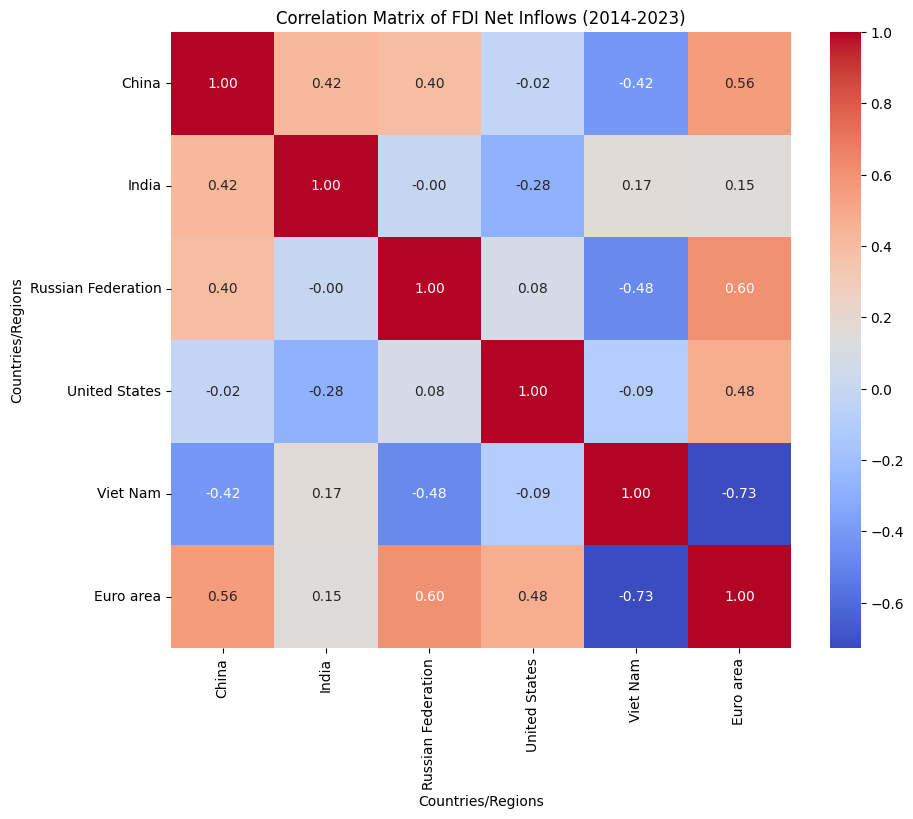


Correlation of FDI in Vietnam with other countries/regions:
Country Name
Viet Nam              1.000000
India                 0.170951
United States        -0.093406
China                -0.416342
Russian Federation   -0.475167
Euro area            -0.727065
Name: Viet Nam, dtype: float64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = 'FDI_10yrs.csv'
df = pd.read_csv(file_path)

# Data Cleaning and Preparation
# Remove rows with all NaN values
df.dropna(how='all', inplace=True)
# Remove metadata rows (assuming they can be identified by missing 'Country Name' or specific strings)
df = df[~df['Country Name'].isin(['Data from database', 'Last Updated: 01/28/2025', None])]
df = df.dropna(subset=['Country Name'])

# Select relevant columns and rename year columns
years_cols = [col for col in df.columns if '[YR' in col]
selected_cols = ['Country Name'] + years_cols
df_fdi = df[selected_cols].copy()

# Rename year columns to just year numbers
year_names = [col.split('[YR')[-1].split(']')[0] for col in years_cols]
year_rename_dict = dict(zip(years_cols, year_names))
df_fdi.rename(columns=year_rename_dict, inplace=True)

# Convert year columns to numeric
for year in year_names:
    df_fdi[year] = pd.to_numeric(df_fdi[year], errors='coerce')

# Set 'Country Name' as index and transpose to have years as index and countries as columns
df_fdi.set_index('Country Name', inplace=True)
df_fdi_transposed = df_fdi.transpose()

# Calculate the correlation matrix
correlation_matrix = df_fdi_transposed.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of FDI Net Inflows (2014-2023)')
plt.xlabel('Countries/Regions')
plt.ylabel('Countries/Regions')
plt.show()

# Analyze correlation with Vietnam (VNM)
vietnam_correlations = correlation_matrix['Viet Nam'].sort_values(ascending=False)
print("\nCorrelation of FDI in Vietnam with other countries/regions:")
print(vietnam_correlations)

In [17]:
import pandas as pd
import warnings
from statsmodels.tsa.stattools import grangercausalitytests

warnings.simplefilter("ignore")
# Load the CSV file
file_path = 'FDI_10yrs.csv'
df = pd.read_csv(file_path)

# Data Cleaning and Preparation
# Remove rows with all NaN values
df.dropna(how='all', inplace=True)
# Remove metadata rows
df = df[~df['Country Name'].isin(['Data from database', 'Last Updated: 01/28/2025', None])]
df = df.dropna(subset=['Country Name'])

# Select relevant columns and rename year columns
years_cols = [col for col in df.columns if '[YR' in col]
selected_cols = ['Country Name'] + years_cols
df_fdi = df[selected_cols].copy()

# Rename year columns to just year numbers
year_names = [col.split('[YR')[-1].split(']')[0] for col in years_cols]
year_rename_dict = dict(zip(years_cols, year_names))
df_fdi.rename(columns=year_rename_dict, inplace=True)

# Convert year columns to numeric
for year in year_names:
    df_fdi[year] = pd.to_numeric(df_fdi[year], errors='coerce')

# Set 'Country Name' as index and transpose to have years as index and countries as columns
df_fdi.set_index('Country Name', inplace=True)
df_fdi_transposed = df_fdi.transpose()

# Granger Causality Test Function
def perform_granger_causality(series1, series2, maxlag=2, verbose=False):
    """
    Performs Granger causality test.

    Parameters:
    series1: Time series 1 (pandas Series).
    series2: Time series 2 (pandas Series).
    maxlag: Maximum lag to consider in the test.
    verbose: If True, prints detailed test results.

    Returns:
    dict: Dictionary of Granger causality test results.
          Returns None if test cannot be performed.
    """
    data = pd.DataFrame({'s1': series1, 's2': series2}).dropna()
    if len(data) < 3: # Need at least 3 data points for grangercausalitytests with maxlag=2
        return None

    try:
        results = grangercausalitytests(data[['s2', 's1']], maxlag=maxlag, verbose=verbose)
        return results
    except Exception as e:
        print(f"Error during Granger causality test: {e}")
        return None


# Analyze Granger Causality with Vietnam (VNM)
vietnam_fdi = df_fdi_transposed['Viet Nam']
countries = [col for col in df_fdi_transposed.columns if col != 'Viet Nam']
max_lag = 2 # Considering max lag of 2 due to limited data points
significance_level = 0.05

print("Granger Causality Analysis with Vietnam FDI:\n")

for country in countries:
    country_fdi = df_fdi_transposed[country]

    # Test if country Granger-causes Vietnam
    gc_country_to_vn_results = perform_granger_causality(vietnam_fdi, country_fdi, maxlag=max_lag, verbose=False)
    if gc_country_to_vn_results:
        p_value_country_to_vn = gc_country_to_vn_results[max_lag][0]['ssr_ftest'][1]
        if p_value_country_to_vn < significance_level:
            causality_country_to_vn = "YES"
        else:
            causality_country_to_vn = "NO"
    else:
        causality_country_to_vn = "INCONCLUSIVE (Not enough data)"
        p_value_country_to_vn = "N/A"


    # Test if Vietnam Granger-causes country
    gc_vn_to_country_results = perform_granger_causality(country_fdi, vietnam_fdi, maxlag=max_lag, verbose=False)
    if gc_vn_to_country_results:
        p_value_vn_to_country = gc_vn_to_country_results[max_lag][0]['ssr_ftest'][1]
        if p_value_vn_to_country < significance_level:
            causality_vn_to_country = "YES"
        else:
            causality_vn_to_country = "NO"
    else:
        causality_vn_to_country = "INCONCLUSIVE (Not enough data)"
        p_value_vn_to_country = "N/A"


    print(f"Country: {country}")
    print(f"  Does {country} Granger-cause Viet Nam FDI? {causality_country_to_vn} (p-value: {p_value_country_to_vn})")
    print(f"  Does Viet Nam Granger-cause {country} FDI? {causality_vn_to_country} (p-value: {p_value_vn_to_country})")
    print("-" * 50)


print("\nInterpretation:")
print(f"* Significance level used: {significance_level}")
print("* 'YES' indicates that we reject the null hypothesis of no Granger causality at the chosen significance level.")
print("* 'NO' indicates we fail to reject the null hypothesis.")
print("* 'INCONCLUSIVE' suggests that the test could not be reliably performed, possibly due to insufficient data points after handling missing values for a given pair.")
print("* Granger causality does not imply true causation, but rather predictive precedence.")

Granger Causality Analysis with Vietnam FDI:

Country: China
  Does China Granger-cause Viet Nam FDI? NO (p-value: 0.5202806307726926)
  Does Viet Nam Granger-cause China FDI? NO (p-value: 0.7299359509795144)
--------------------------------------------------
Country: India
  Does India Granger-cause Viet Nam FDI? NO (p-value: 0.32198844128482734)
  Does Viet Nam Granger-cause India FDI? YES (p-value: 0.013034263445456853)
--------------------------------------------------
Country: Russian Federation
  Does Russian Federation Granger-cause Viet Nam FDI? NO (p-value: 0.43611912565773797)
  Does Viet Nam Granger-cause Russian Federation FDI? NO (p-value: 0.8929423458676816)
--------------------------------------------------
Country: United States
  Does United States Granger-cause Viet Nam FDI? NO (p-value: 0.8834154669190696)
  Does Viet Nam Granger-cause United States FDI? NO (p-value: 0.2984217685104299)
--------------------------------------------------
Country: Euro area
  Does Euro